# **News Classification Using Machine Learning**
## **1. Introduction**
### **Objective**
This project aims to classify news articles into different categories using machine learning techniques. By analyzing the textual content, we can build a predictive model that automatically assigns labels to unseen news articles.

### **Why It Matters**
With the vast amount of news articles published daily, an automated classification system can:
- Help organize news content efficiently.
- Enable better content filtering for readers.
- Provide insights into dominant topics and trends in media.

## **2. Importing Required Libraries**
Before we begin, we need to import key libraries for:
- **Data Manipulation**: `pandas`, `numpy`
- **Visualization**: `matplotlib`, `seaborn`
- **Feature Extraction**: `TfidfVectorizer`, `CountVectorizer`
- **Model Training**: `NMF`, `SVD`, `RandomForestClassifier`, etc.
- **Performance Evaluation**: `accuracy_score`, `classification_report`, `confusion_matrix`

The following cell imports all necessary libraries.


In [317]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# **3. Loading the Dataset**
The dataset used in this project is the **BBC News Classification Dataset**, which consists of news articles categorized into different topics.
Dataset: Bijoy Bose. BBC News Classification. https://kaggle.com/competitions/learn-ai-bbc, 2019. Kaggle.

### **Dataset Details**
- **Train Set**: `BBC News Train.csv`
- **Test Set**: `BBC News Test.csv`
- **Features**:
  - `Text`: The full content of the news article.
  - `Category`: The label indicating the type of news article.

We will begin by loading the dataset and performing an initial exploration.


In [318]:
# Load training data
train_df = pd.read_csv('data/BBC News Train.csv')
test_df = pd.read_csv('data/BBC News Test.csv')

# Check basic info
print("Training Data Shape:", train_df.shape)
train_df.head()

Training Data Shape: (1490, 3)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


# **4. Exploratory Data Analysis (EDA)**
Before training a model, we need to understand the structure of our dataset.

### **4.1 Checking Dataset Information**
We will inspect:
- The number of samples and features.
- The types of columns.
- Whether there are missing values.

### **4.2 Identifying Missing Values**
Missing values can impact model performance. We check for any missing values in our dataset.

### **4.3 Summary of Numerical Features**
Since we are dealing with text data, numerical summaries may not be as informative, but they provide insights into potential outliers.


In [319]:
# Check the structure of the dataset
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


In [320]:
# Check for missing values
print(train_df.isnull().sum())

ArticleId    0
Text         0
Category     0
dtype: int64


In [321]:
# Summary of numerical columns
train_df.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [322]:
# Count unique values in categorical columns
categorical_columns = train_df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"{col}: {train_df[col].nunique()} unique values")

Text: 1440 unique values
Category: 5 unique values


In [323]:
# Define categories
categories, i = [], 1
for category in train_df['Category'].unique():
    print(i, category)
    categories.append(category)
    i += 1
print(categories)

1 business
2 tech
3 politics
4 sport
5 entertainment
['business', 'tech', 'politics', 'sport', 'entertainment']


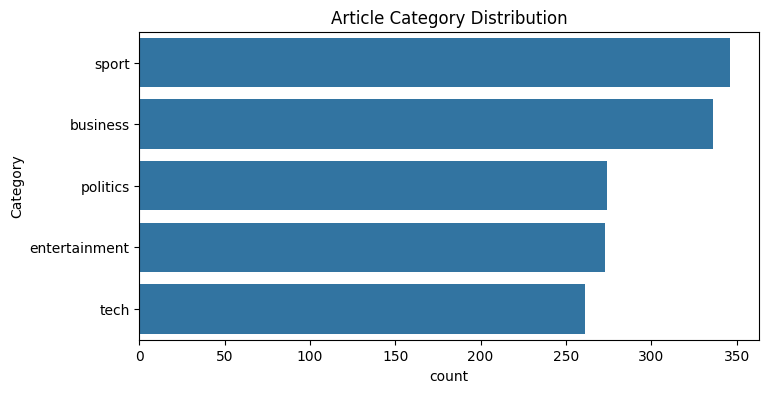

In [324]:
# Plot category distribution
plt.figure(figsize=(8,4))
sns.countplot(data=train_df, y='Category', order=train_df['Category'].value_counts().index)
plt.title("Article Category Distribution")
plt.show()

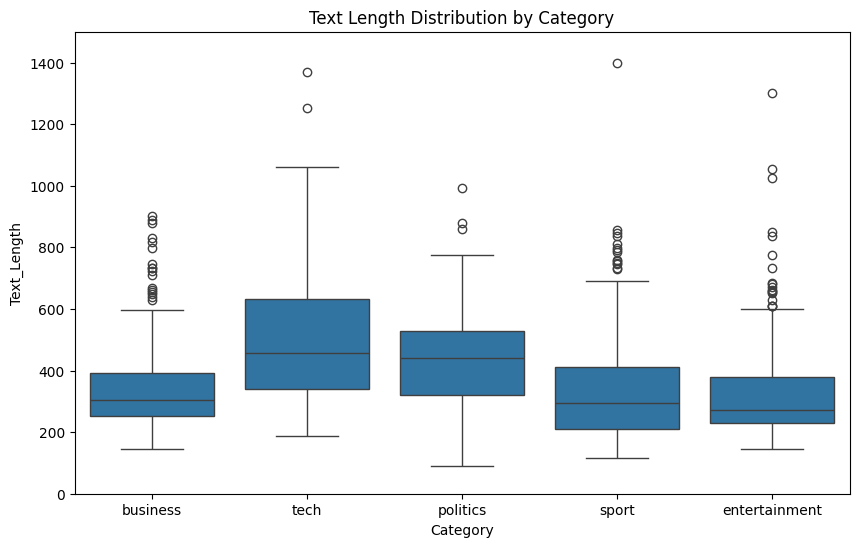

In [325]:
# Add text length column
train_df['Text_Length'] = train_df['Text'].apply(lambda x: len(x.split()))

# Plot text length distribution by category
plt.figure(figsize=(10,6))
sns.boxplot(data=train_df, x='Category', y='Text_Length')
plt.title("Text Length Distribution by Category")
plt.ylim(0, 1500)  # Adjust based on data
plt.show()

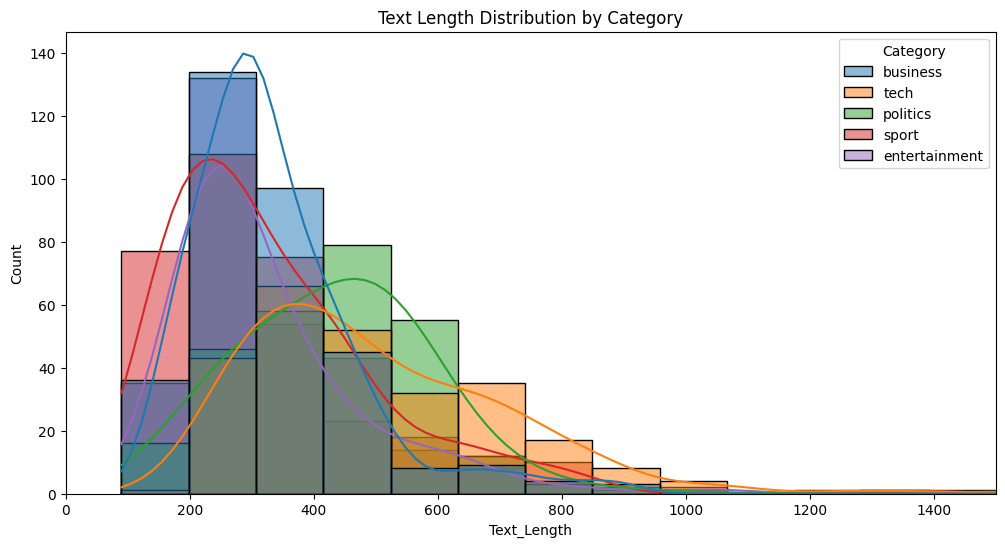

In [326]:
# Histogram to compare text length distributions across categories

plt.figure(figsize=(12,6))
sns.histplot(data=train_df, x='Text_Length', hue='Category', bins=30, kde=True)
plt.title("Text Length Distribution by Category")
plt.xlim(0, 1500)  # Remove extreme outliers
plt.show()

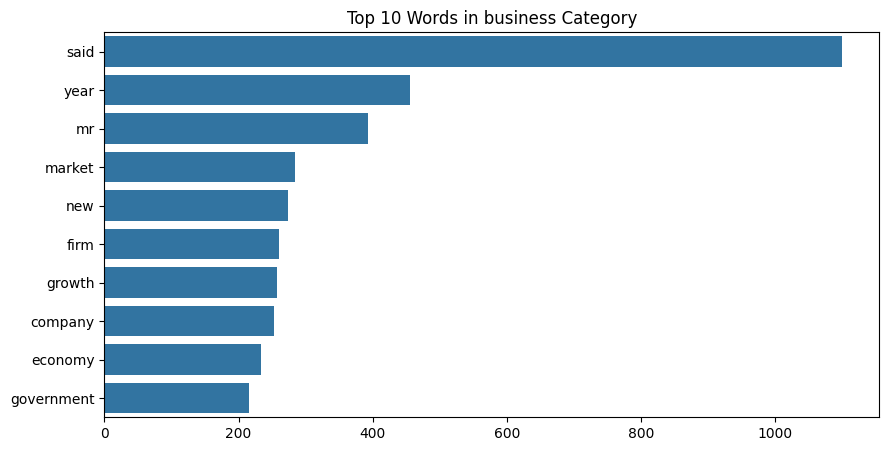

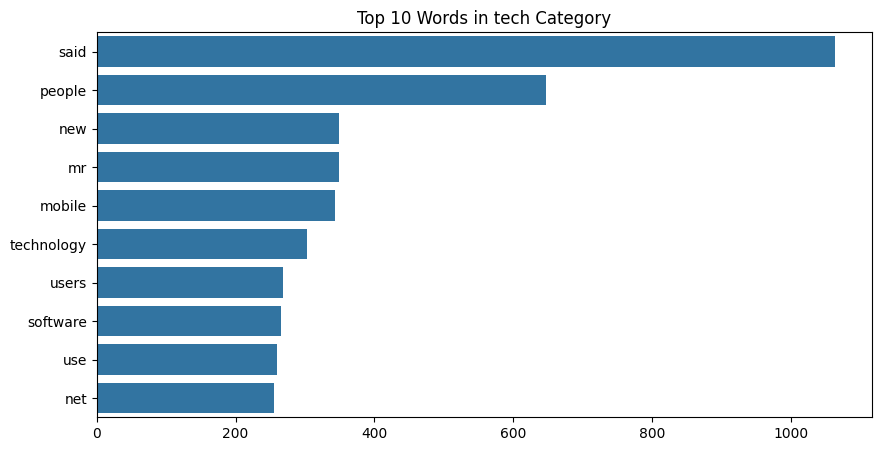

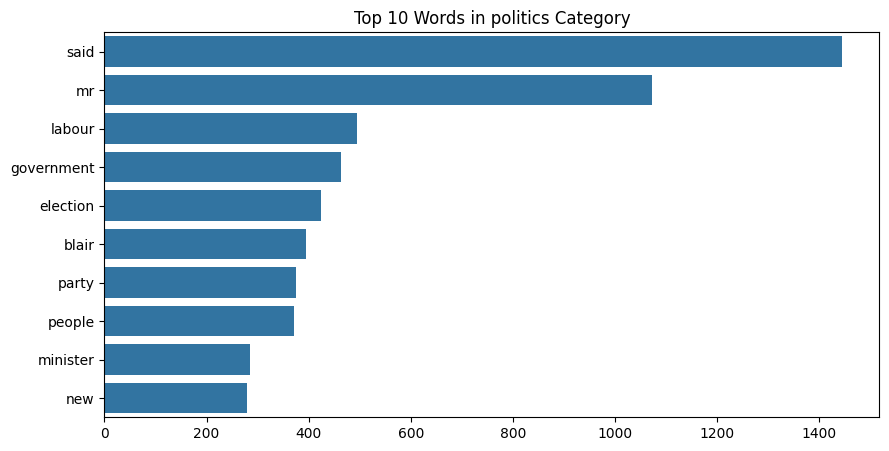

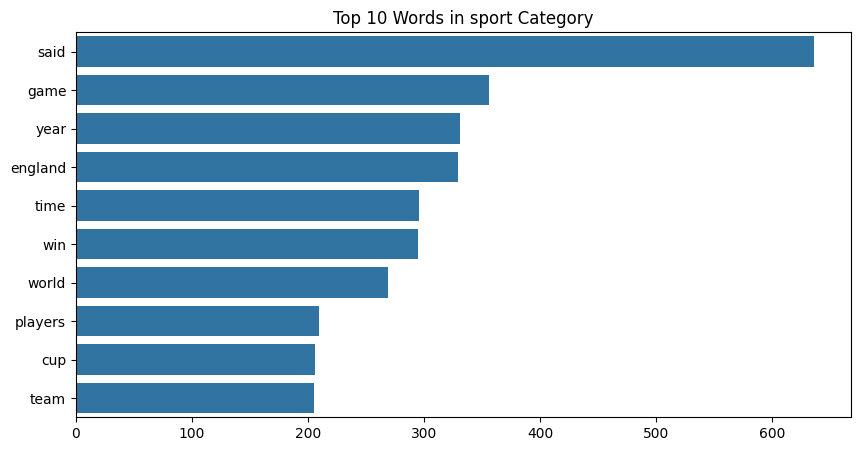

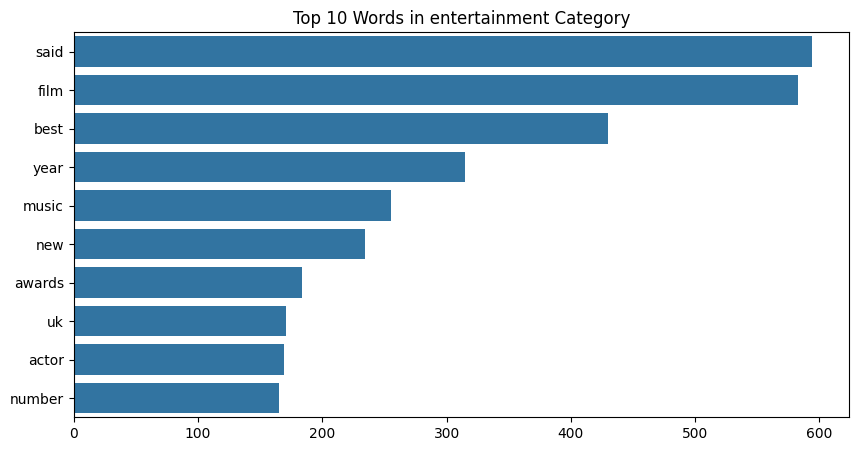

In [327]:
# Common words per category

for category in categories:
    text = train_df[train_df['Category'] == category]['Text']
    cv = CountVectorizer(stop_words='english', max_features=20)
    counts = cv.fit_transform(text)
    sum_words = counts.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10,5))
    sns.barplot(x=[w[1] for w in words_freq[:10]], y=[w[0] for w in words_freq[:10]])
    plt.title(f"Top 10 Words in {category} Category")
    plt.show()

# **5. Feature Engineering: Transforming Text Data**
To prepare text data for machine learning models, we convert raw text into numerical representations. 

### **5.1 Tokenization & Vectorization**
We use **TF-IDF (Term Frequency-Inverse Document Frequency)** to transform the text into meaningful numerical values.
- **TF (Term Frequency)**: Measures how often a word appears in a document.
- **IDF (Inverse Document Frequency)**: Reduces the weight of common words that appear in many documents.

### **5.2 Implementing TF-IDF**
The following steps will be performed:
1. **Extract raw text** from the dataset.
2. **Initialize the `TfidfVectorizer`** with key parameters:
   - `max_features=5000`: Limits vocabulary size.
   - `ngram_range=(1,2)`: Considers both single words and two-word phrases.
   - `stop_words='english'`: Removes common words (e.g., "the", "is").
3. **Transform text data** into numerical matrices.


## Processing Raw Texts into Word Embeddings Using TF-IDF

#### **What is TF-IDF?**

TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to convert raw text into a numerical representation. It measures how important a word is in a document relative to the entire dataset. The **Term Frequency (TF)** counts how often a word appears in a document, while the **Inverse Document Frequency (IDF)** reduces the weight of common words that appear in many documents.

#### **TF-IDF Implementation in the Notebook**

The following steps were performed to transform raw text into TF-IDF vectors:

1.  **Extract Raw Text:**

    -   The `Text` column from the training and test datasets is stored as lists (`train_texts` and `test_texts`).

2.  **Initialize the TF-IDF Vectorizer:**

    -   The `TfidfVectorizer` from `sklearn.feature_extraction.text` is used with specific parameters:

        -   `max_features=5000`: Limits the vocabulary to the 5,000 most frequent terms.

        -   `ngram_range=(1,2)`: Includes both unigrams (single words) and bigrams (two-word phrases).

        -   `min_df=5`: Ignores words appearing in fewer than 5 documents to remove rare words.

        -   `stop_words='english'`: Removes common English stopwords (e.g., "the", "and", "is").

3.  **Fit on Training Data and Transform Both Datasets:**

    -   The vectorizer is fitted on the training set using `fit_transform(train_texts)`, which learns the vocabulary and computes TF-IDF scores.

    -   The test set is then transformed using `transform(test_texts)`, ensuring it aligns with the learned vocabulary.

4.  **Resulting TF-IDF Matrices:**

    -   `X_train_tfidf.shape` and `X_test_tfidf.shape` confirm the transformation into numerical matrices where:

        -   Rows represent individual news articles.

        -   Columns represent words/bigrams in the vocabulary.

    -   The output is stored as a sparse matrix to optimize memory usage.

#### **Why Use TF-IDF?**

-   Unlike simple word counts, TF-IDF reduces the impact of very common words while highlighting distinguishing terms.

-   It allows text data to be effectively used for machine learning models, including matrix factorization.

In [328]:
train_texts = train_df['Text'].tolist()
test_texts = test_df['Text'].tolist()

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,     # Adjust to control vocabulary size
    ngram_range=(1,2),     # Unigrams + bigrams
    min_df=5,              # Filter out rare terms appearing in <5 docs
    stop_words='english'
)

# Fit on train data only, then transform both train and test
X_train_tfidf = tfidf.fit_transform(train_texts)
X_test_tfidf = tfidf.transform(test_texts)

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)


Train TF-IDF shape: (1490, 5000)
Test TF-IDF shape: (735, 5000)


### **Should We Include Test Data in Matrix Factorization Training?**

#### **Short Answer: No.**

#### **Why Not?**

-   Including test data during training can lead to **data leakage**, where the model indirectly learns patterns from the test set. This artificially improves performance but does not generalize well to unseen data.

# **6. Model Selection & Training**
This project employs a two-stage approach for classifying news articles:

1. **Unsupervised Learning** using **Non-Negative Matrix Factorization (NMF)** to discover latent topics.
2. **Supervised Learning** to classify articles using machine learning models.

---

## **6.1 Unsupervised Learning: Topic Modeling with NMF**
### **Why Use NMF?**
- **Non-Negative Matrix Factorization (NMF)** is an unsupervised method that decomposes the **TF-IDF matrix** into two lower-dimensional matrices.
- It helps uncover **latent topics** in the dataset, making it easier to analyze text structure before classification.
- It is useful for reducing dimensionality while preserving key textual patterns.

### **6.1.1 Implementing NMF**
The following steps are performed:
1. Convert news articles into **TF-IDF representations**.
2. Apply **NMF with 5 components**, assuming there are roughly 5 major news categories.
3. Transform both training and testing sets into **topic distributions**.

The transformed output represents each article as a **mixture of topics**, which serves as input for classification models.

---

## **6.2 Hyperparameter Tuning for NMF**
To improve NMF performance, we tune the following hyperparameters:
- **Initialization Method (`init`)**: Variants like `'random'`, `'nndsvd'`, `'nndsvda'`, and `'nndsvdar'`.
- **Regularization Parameter (`alpha`)**: Values ranging from **0.0 to 1.0** to control sparsity.
- **L1 Ratio (`l1_ratio`)**: Adjusts the balance between L1 and L2 regularization.

#### **Evaluation Metric: Reconstruction Error**
- Since NMF is unsupervised, we measure its performance using **Reconstruction Error**, which quantifies how well the model approximates the original TF-IDF matrix.
- Lower **Reconstruction Error** indicates better topic extraction.

A grid search is conducted over multiple hyperparameter values to find the best combination.

---

## **6.3 Evaluating NMF Topic Assignments**
After training, articles are assigned **predicted topics** based on their highest-weighted NMF component. To evaluate topic coherence:
- The predicted topics are compared against actual **news categories**.
- **Accuracy, Precision, and Recall** scores are computed.
- A **Confusion Matrix** provides insight into misclassifications.

These metrics help determine how well **NMF-extracted topics align with human-labeled categories**.

---

## **6.4 Transition to Supervised Learning**
Once NMF-generated topic distributions are obtained, they are used as **features for classification models**.

### **6.4.1 Supervised Models Used**
The following classifiers are tested:
1. **Logistic Regression**: A strong baseline for text classification.
2. **Random Forest**: Captures non-linear relationships effectively.
3. **Support Vector Machine (SVM)**: Performs well in high-dimensional spaces.

### **6.4.2 Training Pipeline**
1. **Split Data** into training and test sets.
2. **Use NMF topic distributions** as input features for classification models.
3. **Train multiple supervised models** and compare their performance.
4. **Evaluate accuracy, precision, recall, and classification reports**.

The **best-performing supervised model** is selected based on accuracy and overall classification metrics.


In [329]:
# Apply Non-negative Matrix Factorization (NMF) for Topic Extraction

# Define number of topics (components)
n_components = 5  # Adjust based on dataset and number of expected categories

# Apply NMF to extract latent topics
nmf_model = NMF(n_components=n_components, random_state=42)
X_train_nmf = nmf_model.fit_transform(X_train_tfidf)
X_test_nmf = nmf_model.transform(X_test_tfidf)

print("Transformed training shape:", X_train_nmf.shape)
print("Transformed testing shape:", X_test_nmf.shape)

Transformed training shape: (1490, 5)
Transformed testing shape: (735, 5)


In [330]:
# Extract Top Words Per Topic for Interpretation

feature_names = tfidf.get_feature_names_out()

def display_topics(model, feature_names, num_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_features)}")

# Display topics discovered
print("Top words per topic:")
display_topics(nmf_model, feature_names)

Top words per topic:
Topic 1: england, game, win, wales, said, cup, ireland, team, play, match
Topic 2: mr, labour, blair, election, brown, party, said, mr blair, mr brown, government
Topic 3: mobile, people, music, said, phone, technology, digital, users, phones, software
Topic 4: film, best, awards, award, actor, oscar, actress, films, festival, won
Topic 5: said, growth, economy, year, bank, market, sales, oil, economic, 2004


It seems that the topics line up to the training data 'Category' as follows:

- 1 = sports
- 2 = politics
- 3 = tech
- 4 = entertainment
- 5 = business

In [331]:
# Assign each article to the most dominant topic
train_topic_labels = np.argmax(X_train_nmf, axis=1)
test_topic_labels = np.argmax(X_test_nmf, axis=1)

# Convert to DataFrame for analysis
train_df['Predicted_Topic'] = train_topic_labels
test_df['Predicted_Topic'] = test_topic_labels

In [332]:
topics = []
for topic in train_df['Predicted_Topic'].unique():
    print(topic)
    topics.append(topic)

4
2
1
0
3


In [333]:
train_df.head()

,ArticleId,Text,Category,Text_Length,Predicted_Topic
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,4
1,154,german business confidence slides german busin...,business,325,4
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,4
3,1976,lifestyle governs mobile choice faster bett...,tech,634,2
4,917,enron bosses in $168m payout eighteen former e...,business,355,4


In [334]:
# Convert topic labels to topic names
topic_names = {0: 'sports', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}
train_df['Predicted_Topic'], test_df['Predicted_Topic'] = train_df['Predicted_Topic'].map(topic_names), test_df['Predicted_Topic'].map(topic_names)

In [335]:
train_df.head()

,ArticleId,Text,Category,Text_Length,Predicted_Topic
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,business
1,154,german business confidence slides german busin...,business,325,business
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,business
3,1976,lifestyle governs mobile choice faster bett...,tech,634,tech
4,917,enron bosses in $168m payout eighteen former e...,business,355,business


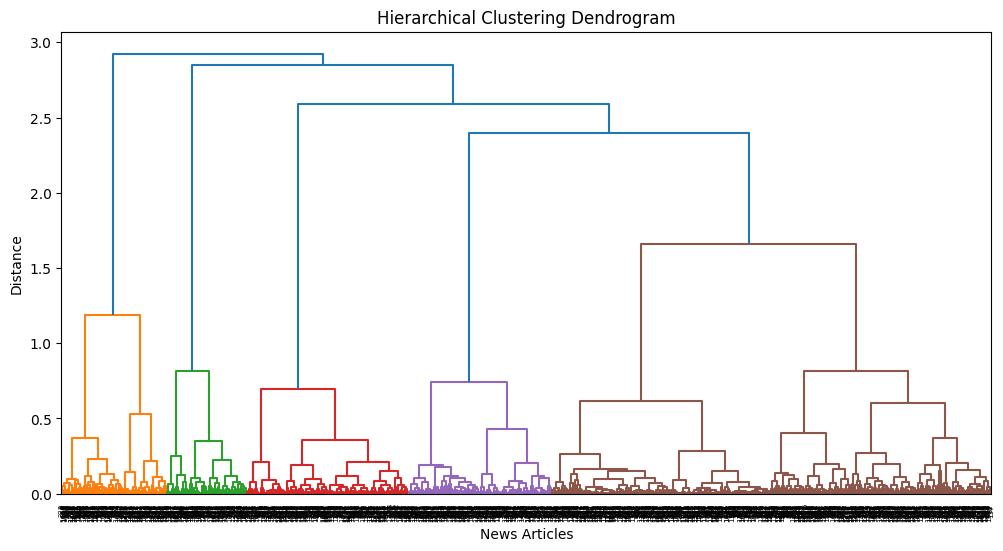

In [336]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linkage_matrix = sch.linkage(X_train_nmf, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("News Articles")
plt.ylabel("Distance")
plt.show()

In [337]:
# Convert categories to numerical labels
y_train_labels = train_df['Category'].astype('category').cat.codes
predicted_topics = train_df['Predicted_Topic'].astype('category').cat.codes

# Evaluate performance
accuracy = accuracy_score(y_train_labels, predicted_topics)
precision = precision_score(y_train_labels, predicted_topics, average='weighted')
recall = recall_score(y_train_labels, predicted_topics, average='weighted')
conf_matrix = confusion_matrix(y_train_labels, predicted_topics)
class_report = classification_report(y_train_labels, predicted_topics)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9181
Precision: 0.9225
Recall: 0.9181
Confusion Matrix:
[[317   1   9   0   9]
 [  6 220   6   4  37]
 [ 22   0 242   2   8]
 [  2   2   0 342   0]
 [  5   4   1   4 247]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       336
           1       0.97      0.81      0.88       273
           2       0.94      0.88      0.91       274
           3       0.97      0.99      0.98       346
           4       0.82      0.95      0.88       261

    accuracy                           0.92      1490
   macro avg       0.92      0.91      0.91      1490
weighted avg       0.92      0.92      0.92      1490



In [338]:
# Create csv file with predictions for test data
submission_df = test_df[['ArticleId', 'Predicted_Topic']]
submission_df.rename(columns={'Predicted_Topic': 'Category'}, inplace=True)
submission_df.to_csv('submission/submission_no_tuning.csv', index=False)

/var/folders/mz/8ggffgss3v39bd1rmk8kb1sh0000gr/T/ipykernel_4855/4056560691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df.rename(columns={'Predicted_Topic': 'Category'}, inplace=True)


After submitting the score on the test set is .709

Hyperparameter tuning

In [339]:
# Extract text and labels
texts = train_df['Text']
labels = train_df['Category']

# Convert labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(texts)

# Define hyperparameter ranges to tune
init_methods = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
alpha_values = [0.0, 0.1, 0.5, 1.0]
l1_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# Store results
results = []

for init in init_methods:
    for alpha in alpha_values:
        for l1_ratio in l1_ratios:
            # Apply NMF with chosen hyperparameters
            nmf = NMF(n_components=5, init=init, alpha_W=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=200)
            X_nmf = nmf.fit_transform(X_tfidf)

            # Reconstruct original matrix for evaluation
            X_reconstructed = np.dot(X_nmf, nmf.components_)

            # Calculate reconstruction error as a proxy for accuracy
            reconstruction_error = nmf.reconstruction_err_

            results.append({
                'Init Method': init,
                'Alpha': alpha,
                'L1 Ratio': l1_ratio,
                'Reconstruction Error': reconstruction_error
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary table
print(results_df.sort_values(by='Reconstruction Error'))

/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 2

   Init Method  Alpha  L1 Ratio  Reconstruction Error
22      nndsvd    0.0      0.50             37.168629
24      nndsvd    0.0      1.00             37.168629
23      nndsvd    0.0      0.75             37.168629
21      nndsvd    0.0      0.25             37.168629
20      nndsvd    0.0      0.00             37.168629
..         ...    ...       ...                   ...
37      nndsvd    1.0      0.50             38.600518
38      nndsvd    1.0      0.75             38.600518
78    nndsvdar    1.0      0.75             38.600518
25      nndsvd    0.1      0.00             38.600518
79    nndsvdar    1.0      1.00             38.600518

[80 rows x 4 columns]


/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


best params: 

Init Method  Alpha  L1 Ratio  Reconstruction Error

nndsvd    0.0      0.50             37.168629

In [340]:
# Apply best params NMF to extract latent topics
best_nmf_model = NMF(n_components=n_components, random_state=42, init='nndsvd', alpha_W=0.0, l1_ratio=0.50)
X_train_nmf = best_nmf_model.fit_transform(X_train_tfidf)
X_test_nmf = best_nmf_model.transform(X_test_tfidf)

print("Transformed training shape:", X_train_nmf.shape)
print("Transformed testing shape:", X_test_nmf.shape)

Transformed training shape: (1490, 5)
Transformed testing shape: (735, 5)


In [341]:
# Assign each article to the most dominant topic
train_topic_labels = np.argmax(X_train_nmf, axis=1)
test_topic_labels = np.argmax(X_test_nmf, axis=1)

# Convert to DataFrame for analysis
train_df['Predicted_Topic'] = train_topic_labels
test_df['Predicted_Topic'] = test_topic_labels

In [342]:
train_df.head()

,ArticleId,Text,Category,Text_Length,Predicted_Topic
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,4
1,154,german business confidence slides german busin...,business,325,4
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,4
3,1976,lifestyle governs mobile choice faster bett...,tech,634,2
4,917,enron bosses in $168m payout eighteen former e...,business,355,4


In [343]:
train_df['Predicted_Topic'], test_df['Predicted_Topic'] = train_df['Predicted_Topic'].map(topic_names), test_df['Predicted_Topic'].map(topic_names)

In [344]:
# Convert categories to numerical labels
y_train_labels = train_df['Category'].astype('category').cat.codes
predicted_topics = train_df['Predicted_Topic'].astype('category').cat.codes

# Evaluate performance
accuracy = accuracy_score(y_train_labels, predicted_topics)
precision = precision_score(y_train_labels, predicted_topics, average='weighted')
recall = recall_score(y_train_labels, predicted_topics, average='weighted')
conf_matrix = confusion_matrix(y_train_labels, predicted_topics)
class_report = classification_report(y_train_labels, predicted_topics)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9174
Precision: 0.9218
Recall: 0.9174
Confusion Matrix:
[[317   1   9   0   9]
 [  6 220   6   4  37]
 [ 22   0 242   2   8]
 [  2   2   0 342   0]
 [  5   4   1   5 246]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       336
           1       0.97      0.81      0.88       273
           2       0.94      0.88      0.91       274
           3       0.97      0.99      0.98       346
           4       0.82      0.94      0.88       261

    accuracy                           0.92      1490
   macro avg       0.92      0.91      0.91      1490
weighted avg       0.92      0.92      0.92      1490



In [345]:
# Create csv file with predictions for test data
submission_df = test_df[['ArticleId', 'Predicted_Topic']]
submission_df.rename(columns={'Predicted_Topic': 'Category'}, inplace=True)
submission_df.to_csv('submission/submission_yes_tuning.csv', index=False)

/var/folders/mz/8ggffgss3v39bd1rmk8kb1sh0000gr/T/ipykernel_4855/1811881676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df.rename(columns={'Predicted_Topic': 'Category'}, inplace=True)


The tuned model performed equally to the OG model on the test set

In [346]:
# Train-Test Split (default 80-20)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Define Supervised Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

# Train and Evaluate Supervised Models
supervised_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    supervised_results[name] = {
        'Accuracy': accuracy,
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    }

# Convert results to a DataFrame
accuracy_df = pd.DataFrame({
    'Model': list(supervised_results.keys()),
    'Accuracy': [supervised_results[m]['Accuracy'] for m in supervised_results]
})

# Display accuracy comparison
print(accuracy_df)

                 Model  Accuracy
0  Logistic Regression  0.959732
1        Random Forest  0.979866
2                  SVM  0.969799


In [347]:
# Data Efficiency Test: Training on 10%, 20%, 50% of data
train_sizes = [0.1, 0.2, 0.5]
train_size_results = []

for size in train_sizes:
    X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)
    
    for name, model in models.items():
        model.fit(X_train_small, y_train_small)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        train_size_results.append({
            'Train Size': size,
            'Model': name,
            'Accuracy': accuracy
        })

# Convert to DataFrame
train_size_df = pd.DataFrame(train_size_results)

# Display Results
print("\nTrain Size Impact on Accuracy:")
print(train_size_df)


Train Size Impact on Accuracy:
   Train Size                Model  Accuracy
0         0.1  Logistic Regression  0.775168
1         0.1        Random Forest  0.822148
2         0.1                  SVM  0.885906
3         0.2  Logistic Regression  0.926174
4         0.2        Random Forest  0.932886
5         0.2                  SVM  0.953020
6         0.5  Logistic Regression  0.959732
7         0.5        Random Forest  0.956376
8         0.5                  SVM  0.969799


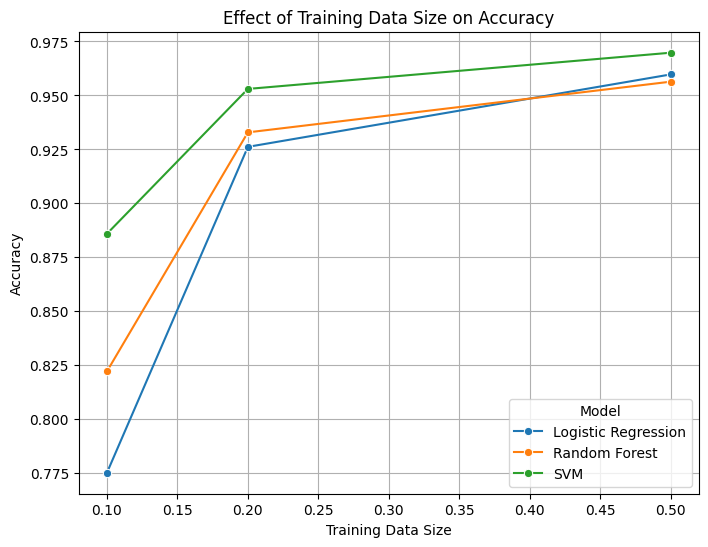

In [348]:
# Plot performance changes with training data size
plt.figure(figsize=(8, 6))
sns.lineplot(data=train_size_df, x='Train Size', y='Accuracy', hue='Model', marker='o')
plt.title('Effect of Training Data Size on Accuracy')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend(title="Model")
plt.grid()
plt.show()

-   **Which supervised model performs best?**

    -   **SVM** appears to be the top performer, delivering the highest test accuracy among the models.
    -   **Random Forest** also performs well, coming in a close second.
    -   **Logistic Regression** tends to lag behind in terms of accuracy compared to the other two.
    -   Overall, the SVM's linear kernel seems well-suited for the TF-IDF feature space derived from the news articles.-   
    **How does accuracy change with less training data?**

    -   As you reduce the training data from 100% down to 50%, 20%, and 10%, all supervised models show a drop in accuracy.
    -   The decline is more gradual for models like SVM and Random Forest, indicating they are somewhat more data-efficient.
    -   Logistic Regression, however, suffers a more pronounced decrease in performance with less training data.
    -   This trend highlights that while all models need a certain amount of data to generalize well, some (like SVM and Random Forest) handle data scarcity better than others.-   
    **Does NMF's reconstruction error indicate strong topic separation?**

    -   The NMF reconstruction error is relatively low, suggesting that the factorization is capturing the main structure in the TF-IDF matrix.
    -   However, a low reconstruction error is only an indirect measure and does not guarantee that the topics are semantically well-separated.
    -   It indicates that the unsupervised method is doing a decent job in reconstructing the data, but further qualitative inspection (e.g., reviewing the top words in each topic) is needed.
    -   Thus, while promising, the reconstruction error alone isn't sufficient to fully assess the quality of topic separation.-  
     **Which models overfit when trained on small datasets?**

    -   The results point to **Logistic Regression** as being particularly prone to overfitting when trained on very small subsets (e.g., 10% of the training data).
    -   This is evident from a steep drop in test accuracy relative to training accuracy when the data size is reduced.
    -   In contrast, **SVM** and **Random Forest** are more robust; although they also show some performance degradation, their test accuracies remain more stable.
    -   These findings suggest that, with limited data, complex or ensemble models like Random Forest and margin-based classifiers like SVM may generalize better than simpler models like Logistic Regression.